In [36]:
import re
import pickle
import glob
import csv
import subprocess
import pandas as pd

import matplotlib.pyplot as plt
import scikitplot.plotters as skplt

from sklearn.model_selection import train_test_split
from sklearn import metrics

%matplotlib inline

In [3]:
featFolder = '../EIFD/data/Features/'
timblFolder = 'data/TimblData/'

In [4]:
def loadFeatures(folderpath, recency=0):
    files_feature = [xfile for xfile in glob.glob(folderpath + "*.pickle")]
    preffiles = [re.findall(folderpath + "Features_(.*)labels_(.*)docs_at(.*).pickle",ff)[0] for ff in files_feature]
    datelist = list(reversed([date[2] for date in preffiles]))
    if (recency is 0):
        print("Loading the latest feature file. Date:", datelist[recency])
    elif (recency > len(datelist)-1):
        recency = len(datelist)-1
        print("Loading the earliest feature file. Date:", datelist[recency])
    else:
        print('Date of the features obtained:', datelist[recency])
    filespecs = [file for file in preffiles if file[2] == datelist[recency]][0]
    print('Total length of the feature list:', filespecs[1])
    print('Number of the entities:', filespecs[0])
    filename = folderpath + "Features_" + filespecs[0] + "labels_" + filespecs[1] + "docs_at" + filespecs[2] + ".pickle"
    featlist = pickle.load(open(filename, 'rb'))
    return featlist

In [15]:
def removeLowFreqLabels(dataDF, to_remove=None, threshold=20):
    if (to_remove is None):
        value_counts = dataDF['class'].value_counts()
        to_remove = value_counts[value_counts <= threshold].index  
        # Remove IOB from tags to drop the colums corresponding with their probabilities from the DataFrame
        to_remove = list(set([re.findall('[B].(.*)', cls)[0] for cls in to_remove if re.match('[B].(.*)', cls)]))
    if (len(to_remove) > 0):
        dataDF = dataDF.drop(to_remove, axis=1)
        print('Ignored classes:', to_remove)
        # Add IOB back to ensure that both B and I versions of the tags are removed
        to_remove = ['B.' + cls for cls in to_remove] + ['I.' + cls for cls in to_remove]
        dataDF['class'] = dataDF['class'].replace(to_remove, 'O')
    else:
        print('None of the classes ignored:', to_remove)
    return dataDF

In [6]:
def splitData(dataDF, algorithm='TiMBL', cv=True, testSize=0.20, randomState=42):
    Y = dataDF.pop('class') 
    XDF = dataDF.drop(['foliaId'], axis=1)
    labels = sorted([label for label in Y.unique() if label not in ['O']])
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(XDF, Y, test_size=testSize, random_state=randomState)
    return Xtrain, Xtest, Ytrain, Ytest, labels

In [7]:
def integerizeLabels(y, labels, algorithm=None):
    '''Maps the labels in a list to their corresponding indexes in unique label list.'''
    int_list = []
    labels_o = labels.copy()
    labels_o.append('O')
    for cls in y:
        int_list.append(labels_o.index(cls))    
    return int_list

In [8]:
notUsedFeatures = ["class", "foliaId"]#,"isTitleCase","wordClass","+1:wordClass","-1:wordClass","-2:ner","+2:ner","+2:pos","-2:pos","-1:pos","+1:pos","pos"]

# Initialization

In [67]:
to_remove = ['dmg.bus', 'dmg.ppl.inj', 'dmg.econ', 'dmg.ppl.miss', 'dmg.ppl.evac', 'dmg.ppl.kill', 'dmg.prop', 'resp.donat', 'resp.supply']

In [71]:
featlist = loadFeatures(featFolder)
dataDF = pd.DataFrame(featlist)
dataDF['class'] = dataDF['class'].replace('B.loc.other', 'B.loc.focus')
dataDF['class'] = dataDF['class'].replace('I.loc.other', 'I.loc.focus')
dataDF = dataDF.drop('loc.other', axis=1)
dataDF = removeLowFreqLabels(dataDF, to_remove)
Xtrain, Xtest, Ytrain, Ytest, labels = splitData(dataDF, cv=False, testSize=0.40)

Loading the latest feature file. Date: 2017-03-17T17:50:00
Total length of the feature list: 26598
Number of the entities: 1708
Ignored classes: ['dmg.bus', 'dmg.ppl.inj', 'dmg.econ', 'dmg.ppl.miss', 'dmg.ppl.evac', 'dmg.ppl.kill', 'dmg.prop', 'resp.donat', 'resp.supply']


In [72]:
Xtrain['Z-class'] = Ytrain
Xtest['Z-class'] = Ytest

In [73]:
Xtrain.to_csv(timblFolder + 'flooddata.train', sep='\t', header=False)
Xtest.to_csv(timblFolder + 'flooddata.test', sep='\t', header=False)

In [74]:
i = 1
for v in Xtrain.T.index.values:
    print(i,v)
    i += 1

1 +1:ner
2 +1:pos
3 +1:token
4 +1:wordClass
5 +2:ner
6 +2:pos
7 +2:token
8 -1:ner
9 -1:ner|ner
10 -1:ner|ner|+1:ner
11 -1:pos
12 -1:pos|pos
13 -1:pos|pos|+1:pos
14 -1:token
15 -1:token|token
16 -1:token|token|+1:token
17 -1:wordClass
18 -2:ner
19 -2:ner|-1:ner|ner
20 -2:pos
21 -2:pos|-1:pos|pos
22 -2:token
23 -2:token|-1:token|token
24 event.flood
25 isTitleCase
26 lemma
27 loc.focus
28 loc.supp
29 ner
30 ner|+1:ner
31 ner|+1:ner|+2:ner
32 pos
33 pos|+1:pos
34 pos|+1:pos|+2:pos
35 time
36 token
37 token|+1:token
38 token|+1:token|+2:token
39 wordClass
40 Z-class


In [75]:
i = 0
for v in labels:
    print(i,v)
    i += 1

0 B.event.flood
1 B.loc.focus
2 B.loc.supp
3 B.time
4 I.event.flood
5 I.loc.focus
6 I.loc.supp
7 I.time


# Evaluation

In [77]:
def singleEvalGraphs(Y, filepath, labels):
    predictions = pd.read_csv(filepath, sep='\s+', header=None)
    P = predictions.iloc[:,-1]
    Yint = integerizeLabels(Y, labels, algorithm=None)
    Pint = integerizeLabels(P, labels, algorithm=None)
    skplt.plot_confusion_matrix(Yint, Pint, normalize=True, figsize=(12,12))
    labels = sorted([label for label in list(set(Y)) if label not in ['O']])
    print(metrics.classification_report(Y, P, labels=labels))
    plt.show()

In [78]:
resultfiles = [xfile for xfile in glob.glob(timblFolder + "flooddata.test.*.out")]


  ========  data/TimblData/flooddata.test.IB1.O.gr.k1.out  ========

               precision    recall  f1-score   support

B.event.flood       0.32      0.32      0.32       114
  B.loc.focus       0.32      0.31      0.31       101
   B.loc.supp       0.34      0.29      0.32        41
       B.time       0.37      0.23      0.29        43
I.event.flood       0.30      0.27      0.29        37
  I.loc.focus       0.24      0.18      0.21        22
   I.loc.supp       0.00      0.00      0.00         9
       I.time       0.29      0.19      0.23        21

  avg / total       0.31      0.28      0.29       388



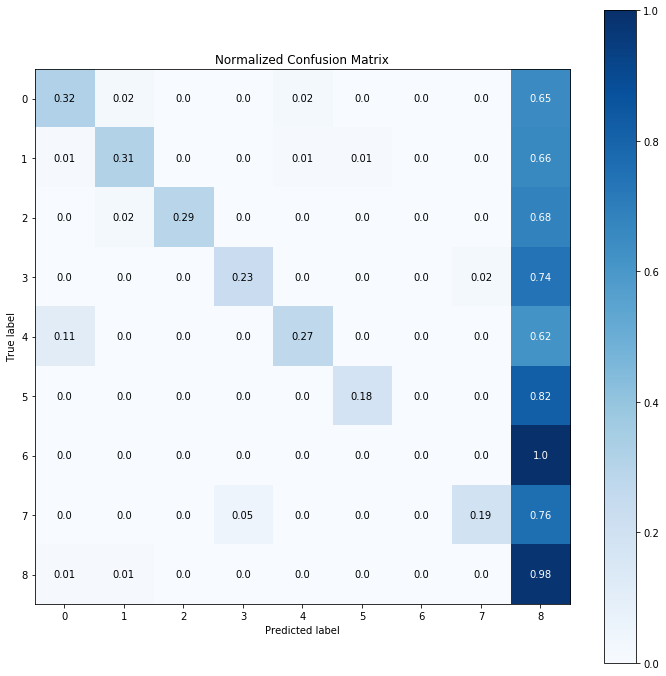


  ========  data/TimblData/flooddata.test.IB1.O.gr.k3.out  ========

               precision    recall  f1-score   support

B.event.flood       0.48      0.13      0.21       114
  B.loc.focus       0.38      0.23      0.29       101
   B.loc.supp       0.47      0.17      0.25        41
       B.time       0.67      0.19      0.29        43
I.event.flood       0.50      0.22      0.30        37
  I.loc.focus       0.25      0.05      0.08        22
   I.loc.supp       0.00      0.00      0.00         9
       I.time       0.20      0.05      0.08        21

  avg / total       0.44      0.16      0.23       388



/Users/ebasar/lamachine/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


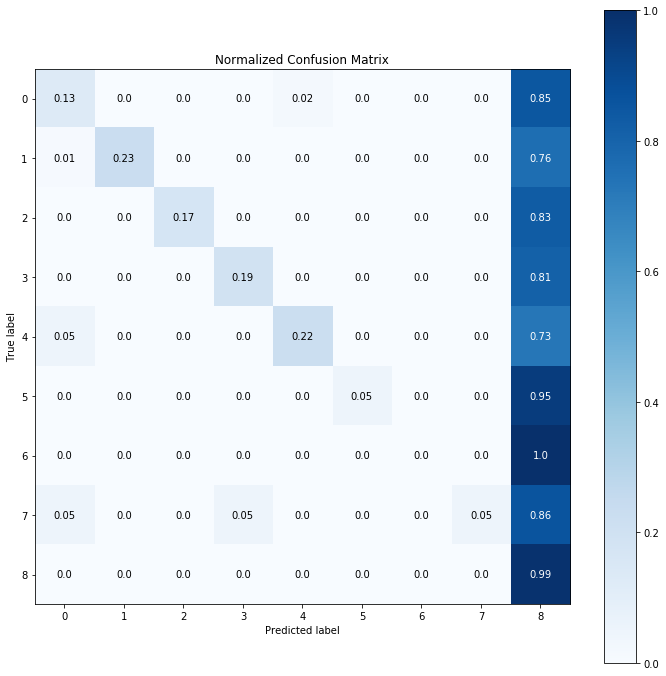


  ========  data/TimblData/flooddata.test.IB1.O.gr.k5.out  ========

               precision    recall  f1-score   support

B.event.flood       0.59      0.09      0.15       114
  B.loc.focus       0.48      0.20      0.28       101
   B.loc.supp       0.58      0.17      0.26        41
       B.time       0.57      0.09      0.16        43
I.event.flood       0.50      0.11      0.18        37
  I.loc.focus       0.00      0.00      0.00        22
   I.loc.supp       0.00      0.00      0.00         9
       I.time       1.00      0.05      0.09        21

  avg / total       0.52      0.12      0.19       388



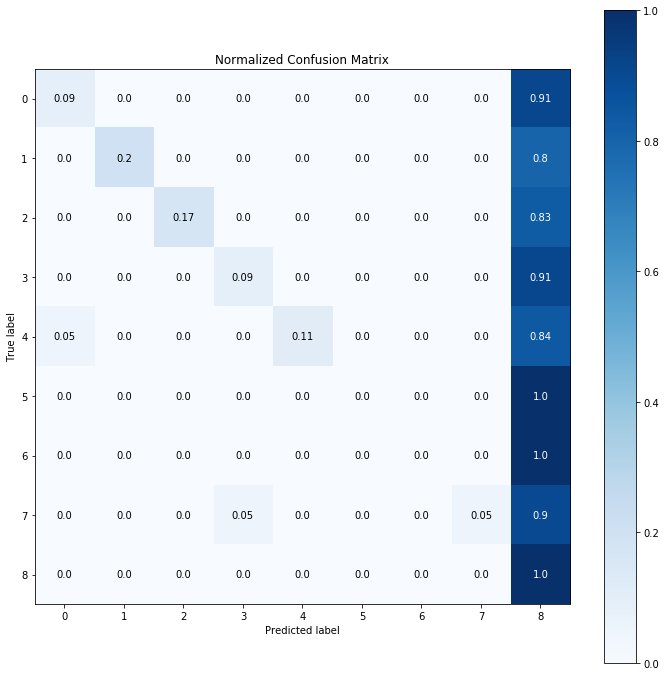

In [79]:
# 0.40
for file in resultfiles:
    print('\n  ========  ' + file + '  ========\n')
    singleEvalGraphs(Ytest, file, labels)


  ========  data/TimblData/flooddata.test.IB1.O.gr.k1.out  ========

               precision    recall  f1-score   support

B.event.flood       0.28      0.30      0.29       136
  B.loc.focus       0.30      0.29      0.30       123
   B.loc.supp       0.36      0.29      0.32        55
       B.time       0.33      0.25      0.29        51
I.event.flood       0.26      0.28      0.27        43
  I.loc.focus       0.21      0.14      0.17        28
   I.loc.supp       0.11      0.08      0.09        13
       I.time       0.30      0.22      0.26        27

  avg / total       0.29      0.27      0.28       476



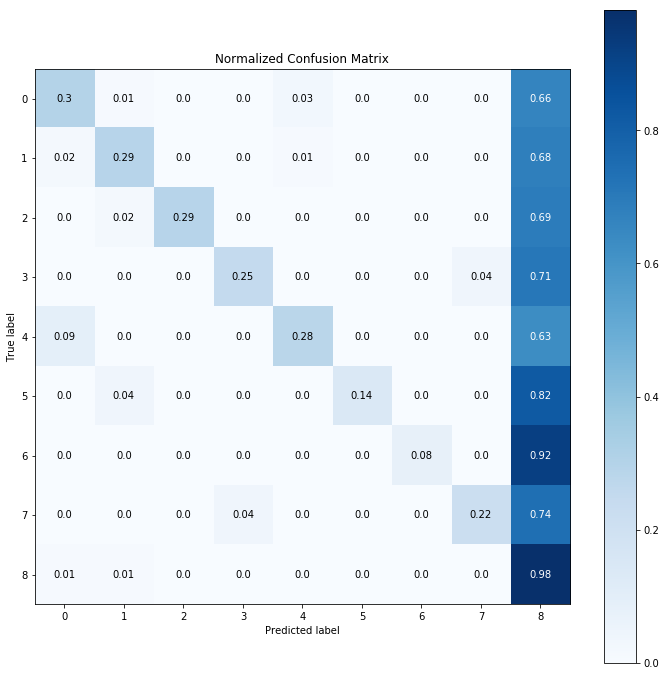


  ========  data/TimblData/flooddata.test.IB1.O.gr.k3.out  ========

               precision    recall  f1-score   support

B.event.flood       0.59      0.12      0.21       136
  B.loc.focus       0.33      0.20      0.24       123
   B.loc.supp       0.59      0.18      0.28        55
       B.time       0.59      0.25      0.36        51
I.event.flood       0.39      0.21      0.27        43
  I.loc.focus       0.25      0.07      0.11        28
   I.loc.supp       0.00      0.00      0.00        13
       I.time       0.60      0.11      0.19        27

  avg / total       0.47      0.16      0.23       476



/Users/ebasar/lamachine/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


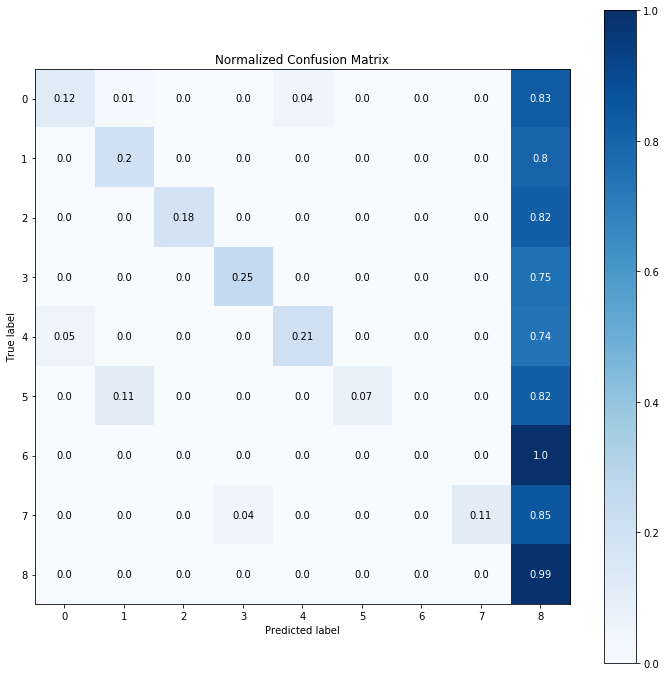

In [70]:
# 0.50
for file in resultfiles:
    print('\n  ========  ' + file + '  ========\n')
    singleEvalGraphs(Ytest, file, labels)


  ========  data/TimblData/flooddata.test.IB1.O.gr.k1.out  ========

               precision    recall  f1-score   support

B.event.flood       0.22      0.24      0.23        51
  B.loc.focus       0.35      0.31      0.33        59
   B.loc.supp       0.35      0.31      0.33        26
       B.time       0.36      0.24      0.29        21
I.event.flood       0.26      0.42      0.32        12
  I.loc.focus       0.00      0.00      0.00         6
   I.loc.supp       0.00      0.00      0.00         7
       I.time       0.30      0.23      0.26        13

  avg / total       0.28      0.26      0.27       195



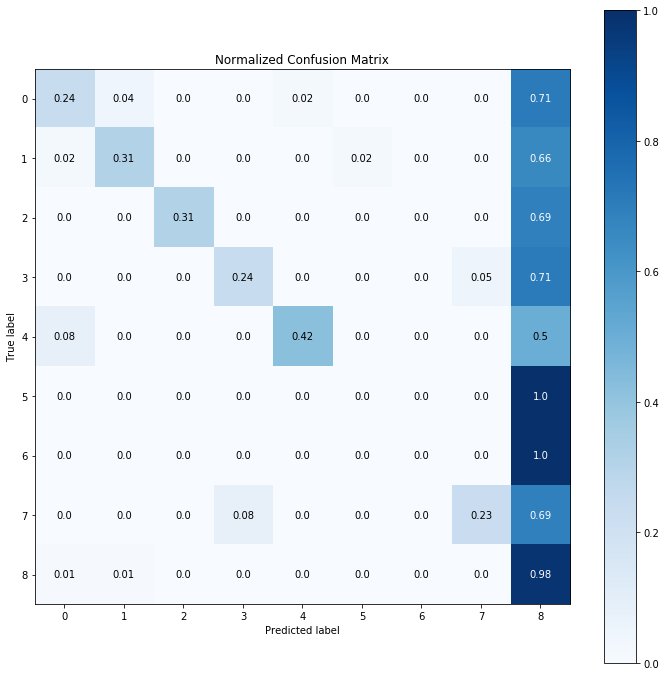


  ========  data/TimblData/flooddata.test.IB1.O.gr.k3.out  ========

               precision    recall  f1-score   support

B.event.flood       0.36      0.10      0.15        51
  B.loc.focus       0.31      0.15      0.20        59
   B.loc.supp       0.50      0.19      0.28        26
       B.time       0.50      0.14      0.22        21
I.event.flood       0.25      0.25      0.25        12
  I.loc.focus       0.33      0.17      0.22         6
   I.loc.supp       0.00      0.00      0.00         7
       I.time       0.67      0.15      0.25        13

  avg / total       0.38      0.14      0.20       195



/Users/ebasar/lamachine/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


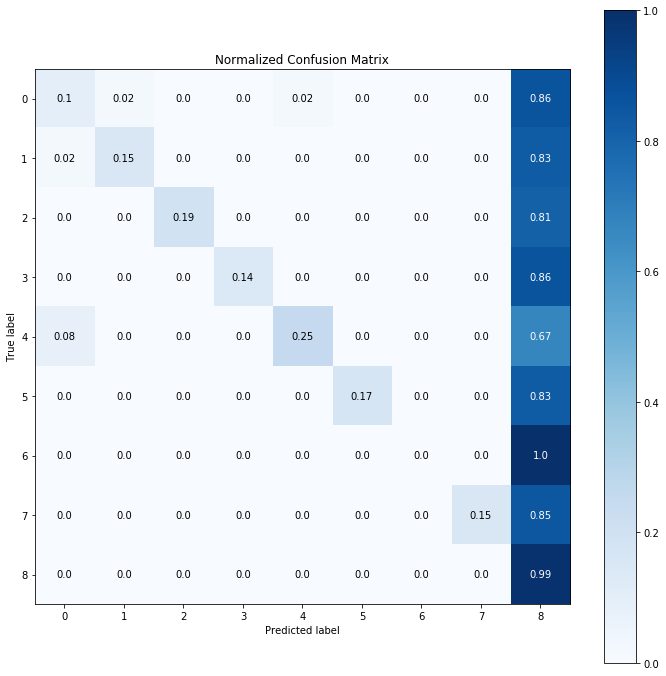

In [60]:
# 0.20
for file in resultfiles:
    print('\n  ========  ' + file + '  ========\n')
    singleEvalGraphs(Ytest, file, labels)